# SVM（回帰）

目次
- Data Preprocessing
    - 0. データを読み込む
    - 1. データ構造を確認する
    - 2. 目的変数・説明変数間の分布を確認する
    - 3. 説明変数間の多重共線性を確認する
    - 4. データの欠損に対処する
    - 5. データの尺度を正規化する
    - 6. 目的変数のデータ分布の偏りに対処する
    - 7. 質的データを変換する
- モデル生成・評価・予測
    - モデル生成
    - モデル評価
    - モデル予測

## Data Preprocessing

### 0. データを読み込む

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('ENB2012_data.csv')
# Dataset URL:https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

### 1. データ構造を確認する

In [3]:
df.info(max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
X1    768 non-null float64
X2    768 non-null float64
X3    768 non-null float64
X4    768 non-null float64
X5    768 non-null float64
X6    768 non-null int64
X7    768 non-null float64
X8    768 non-null int64
Y1    768 non-null float64
Y2    768 non-null float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


変数一覧: 
- X1 Relative Compactness (単位球体との体積比率) 
- X2 Surface Area 床面積 (m^2)
- X3 Wall Area 壁面積 (m^2)
- X4 Roof Area 屋根面積 (m^2)
- X5 Overall Height 高さ (m)
- X6 Orientation 方角 (0:空欄, 2:北, 3:東, 4:南, 5:西)
- X7 Glazing Area ガラス占有率
- X8 Glazing Area Distribution ガラス配置方角（0:空欄, 1:全体, 2:北, 3:東, 4:南, 5:西）
- y1 Heating Load 暖房負荷
- y2 Cooling Load 冷房負荷

変数説明:
- X1～X8：説明変数（うち、X6,X8は質的変数）
- Y1～Y2:目的変数

Y2(Cooling Load)は目的変数として使わないため除外する。

In [4]:
df.drop('Y2', axis=1, inplace=True)

#### 欠損値の有無を確認

In [5]:
df.isnull().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
dtype: int64

欠損値は無し。

### 2. 目的変数・説明変数間の分布を確認する

In [6]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84


#### 基本統計量の確認（質的変数であるX6,X8も含めて）

In [7]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000


#### 質的変数の分布

X6
2    192
3    192
4    192
5    192
dtype: int64

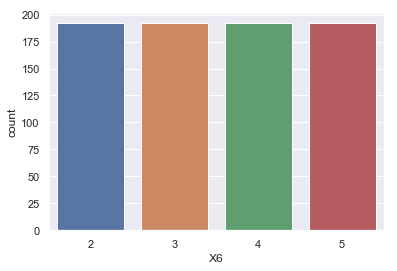

In [8]:
sns.countplot(x='X6', data=df)
df.groupby('X6').size()

X6は完全な一様分布

X8
0     48
1    144
2    144
3    144
4    144
5    144
dtype: int64

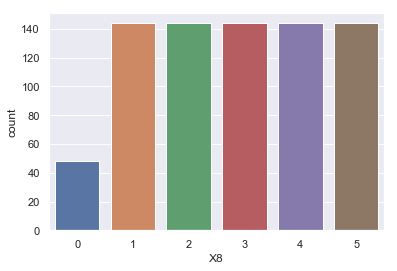

In [9]:
sns.countplot(x='X8', data=df)
df.groupby('X8').size()

X8は「0」のみ 1/3 の件数になっているが、偏りは無いとみなし補正は行わない。

#### 説明変数の分布（多重共線性の確認とその対処も行う）

Seabornでカテゴリ毎に可視化するため、整数型の質的変数 X6,X8を文字列にキャスト

In [10]:
X_df = df[['X1','X2','X3','X4','X5','X6','X7','X8']]

prefix_cat = lambda x: '{}_cat'.format(x)
X_df = X_df.assign(X6_cat = X_df['X6'].map(prefix_cat))
X_df = X_df.assign(X8_cat = X_df['X8'].map(prefix_cat))

X_df.drop(['X6','X8'], axis=1, inplace=True)
X_df.head()

,X1,X2,X3,X4,X5,X7,X6_cat,X8_cat
0,0.98,514.5,294.0,110.25,7.0,0.0,2_cat,0_cat
1,0.98,514.5,294.0,110.25,7.0,0.0,3_cat,0_cat
2,0.98,514.5,294.0,110.25,7.0,0.0,4_cat,0_cat
3,0.98,514.5,294.0,110.25,7.0,0.0,5_cat,0_cat
4,0.90,563.5,318.5,122.50,7.0,0.0,2_cat,0_cat


量的変数間の相関関係を確認する

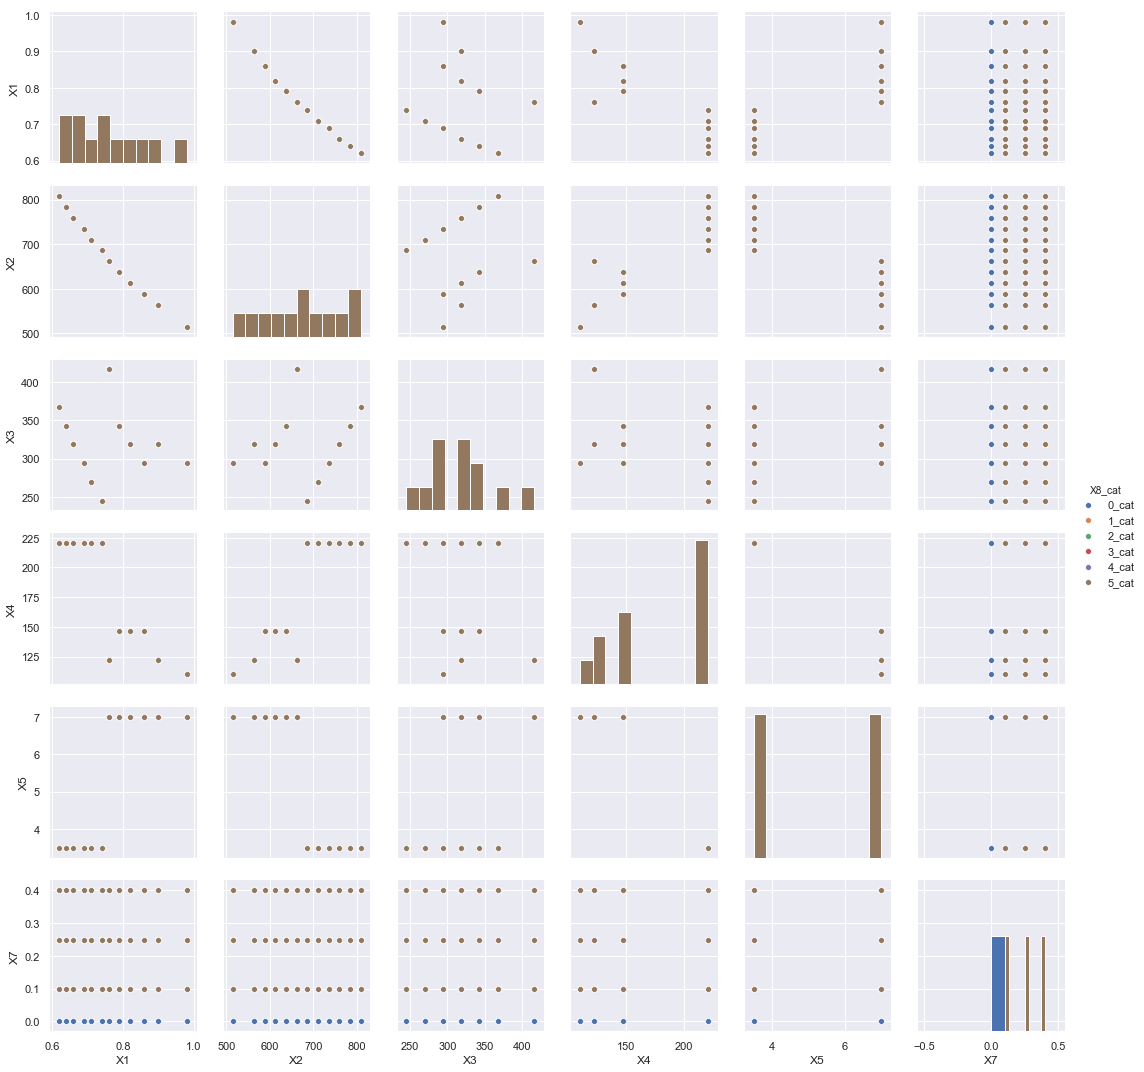

In [11]:
sns.pairplot(X_df, hue='X8_cat', kind='scatter', diag_kind='hist')

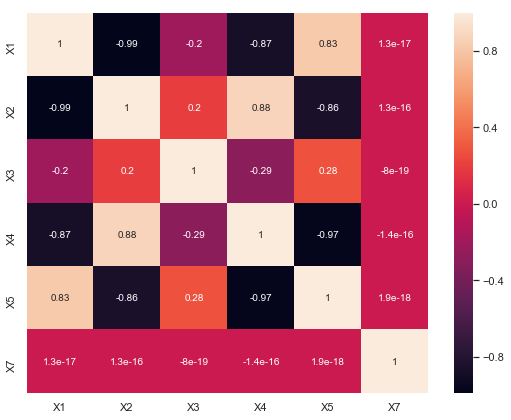

In [12]:
plt.figure(figsize=(9, 7))
sns.heatmap(X_df.corr(),annot=True)

<Figure size 648x504 with 0 Axes>

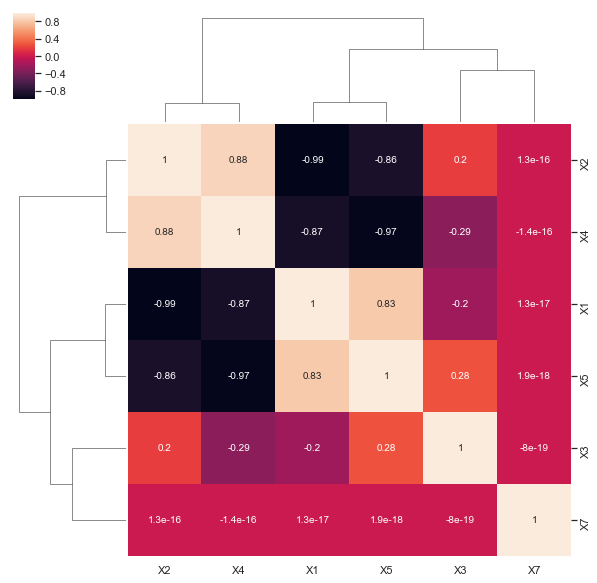

In [13]:
plt.figure(figsize=(9, 7))
sns.clustermap(X_df.corr(),annot=True)

一般論として相関係数の絶対値が0.7以上の場合、強い相関、すなわち多重共線性が認められる。この条件を満たす X1とX5, X2とX4 からそれぞれ片方の変数を消す。

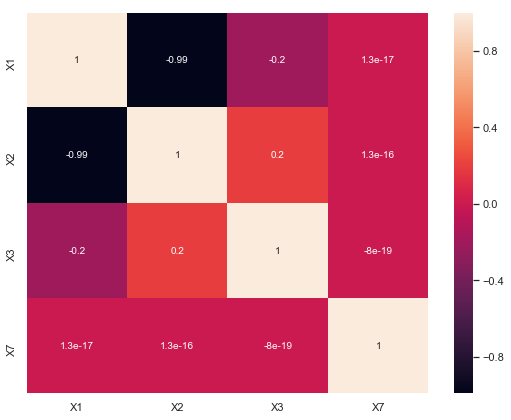

In [14]:
X_df.drop(['X5','X4'], axis=1, inplace=True)
plt.figure(figsize=(9, 7))
sns.heatmap(X_df.corr(),annot=True)

X1, X2間の相関が強いため、X2の方を削除する。

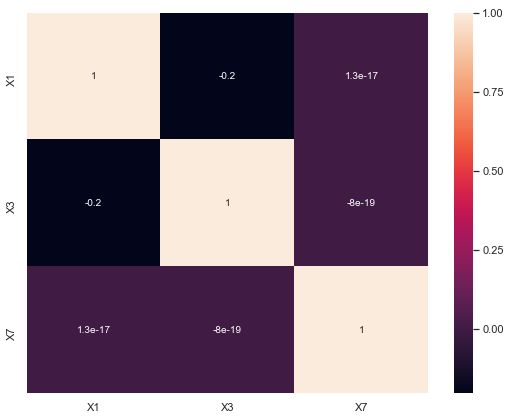

In [15]:
X_df.drop(['X2'], axis=1, inplace=True)
plt.figure(figsize=(9, 7))
sns.heatmap(X_df.corr(),annot=True)

In [16]:
X_df.head()

,X1,X3,X7,X6_cat,X8_cat
0,0.98,294.0,0.0,2_cat,0_cat
1,0.98,294.0,0.0,3_cat,0_cat
2,0.98,294.0,0.0,4_cat,0_cat
3,0.98,294.0,0.0,5_cat,0_cat
4,0.90,318.5,0.0,2_cat,0_cat


#### 目的変数の分布

In [17]:
y_df = df['Y1']

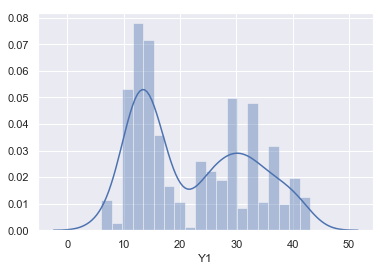

In [18]:
sns.distplot(y_df, bins=20)

ガウス分布的なものが2つあるように見えるが、極端な偏りは無いと見なす。

### 3. 説明変数間の多重共線性を確認する

確認＆対処済み

### 4. データの欠損に対処する

欠損は無いため対処不要

### 5. データの尺度を正規化する

#### 正規化方法を検討するため現時点の説明変数の分布を表示

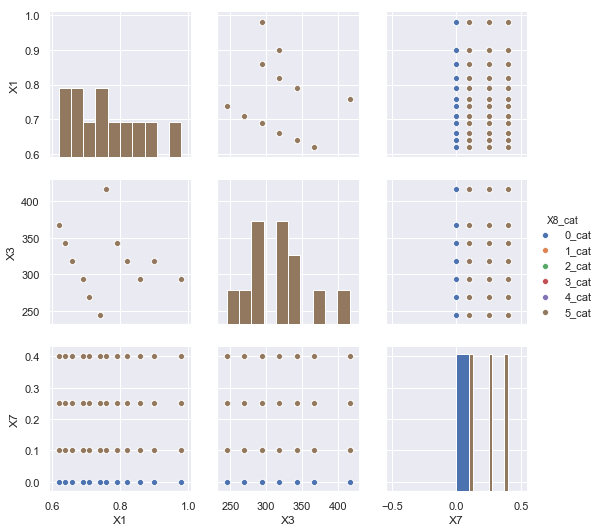

In [19]:
sns.pairplot(X_df, hue='X8_cat', kind='scatter', diag_kind='hist')

- X1とX3は標準正規分布で正規化する。
- X7は正規分布の傾向が無いためMaxMin法で正規化する。

In [20]:
X_df_x1_x3 = X_df[['X1','X3']]
X_df_x7 = X_df['X7']

X_np_sc = StandardScaler().fit_transform(X_df_x1_x3)
X_np_mm = MinMaxScaler().fit_transform(pd.DataFrame(X_df_x7))

X_df_sc = pd.DataFrame(X_np_sc, columns=['X1','X3'])
X_df_mm = pd.DataFrame(X_np_mm, columns=['X7'])

X_df_mm.head()

X_df_std = X_df_sc.join(X_df_mm)
X_df_std.head()

,X1,X3,X7
0,2.041777,-0.561951,0.0
1,2.041777,-0.561951,0.0
2,2.041777,-0.561951,0.0
3,2.041777,-0.561951,0.0
4,1.284979,0.000000,0.0


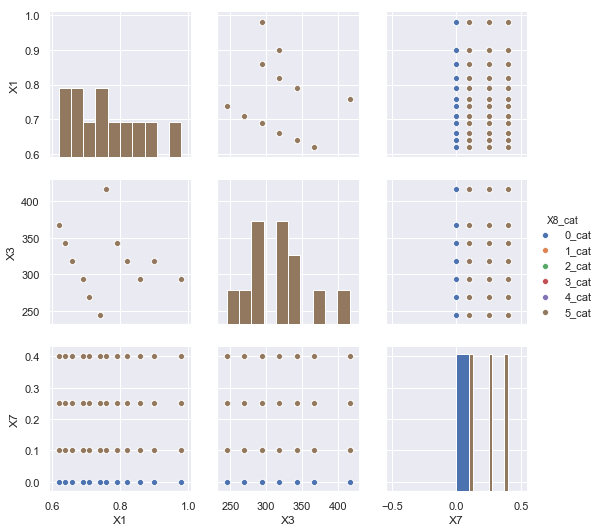

In [21]:
sns.pairplot(X_df, hue='X8_cat', kind='scatter', diag_kind='hist')

### 6. 目的変数のデータ分布の偏りに対処する

目的変数の分布で述べたとおり偏りは無いとみなし対処不要。

### 7. 質的データを変換する

In [22]:
X_df_tmp = X_df_std.join(df[['X6','X8']])
X_df_tmp.head()

,X1,X3,X7,X6,X8
0,2.041777,-0.561951,0.0,2,0
1,2.041777,-0.561951,0.0,3,0
2,2.041777,-0.561951,0.0,4,0
3,2.041777,-0.561951,0.0,5,0
4,1.284979,0.000000,0.0,2,0


In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

onehot_encoder = OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

integer_encoded  = label_encoder.fit_transform(X_df_tmp['X6'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
df_tmp_x6 = pd.DataFrame(onehot_encoded, 
                      columns= ['X6_' + str(i) for i in label_encoder.classes_ ])

integer_encoded  = label_encoder.fit_transform(X_df_tmp['X8'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
df_tmp_x8 = pd.DataFrame(onehot_encoded, 
                      columns= ['X8_' + str(i) for i in label_encoder.classes_ ])

df_tmp = pd.DataFrame(onehot_encoded, columns= label_encoder.classes_)
X_df = pd.concat([X_df_tmp, df_tmp_x6, df_tmp_x8], axis=1)
X_df.head()

,X1,X3,X7,X6,X8,X6_2,X6_3,X6_4,X6_5,X8_0,X8_1,X8_2,X8_3,X8_4,X8_5
0,2.041777,-0.561951,0.0,2,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2.041777,-0.561951,0.0,3,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.041777,-0.561951,0.0,4,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.041777,-0.561951,0.0,5,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.284979,0.000000,0.0,2,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## モデル生成・評価・予測

### モデル生成

#### OneHotEncoding前のX6, X8を説明変数から除外する

In [24]:
X_df.drop(['X6','X8'], axis=1, inplace=True)

#### 学習データと評価データに分割する

In [25]:
X_train, X_test, y_train, y_test = train_test_split( # 返り値はSeries
    X_df,
    y_df, 
    test_size = 300,
    random_state = 0
    )

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(468, 13) (300, 13) (468,) (300,)


#### 交差検証とグリッドサーチを同時に実行する

In [27]:
parameters = { 'C':np.logspace(0,1,20), 'epsilon':np.logspace(-1,1,20)}
grid_search = GridSearchCV(
                    SVR(kernel='rbf'), 
                    parameters, 
                    cv = 5
                )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([ 1.     ,  1.12884,  1.27427,  1.43845,  1.62378,  1.83298,
        2.06914,  2.33572,  2.63665,  2.97635,  3.35982,  3.79269,
        4.28133,  4.83293,  5.45559,  6.15848,  6.95193,  7.8476 ,
        8.85867, 10.     ]), 'epsilon': array([ 0.1    ,  0.12743,  0.16238,  0.20691,  0.26367,  0.33598,
        0.42813,  0.54556,  0.69519,  0.88587,  1.12884,  1.43845,
        1.83298,  2.33572,  2.97635,  3.79269,  4.83293,  6.15848,
        7.8476 , 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### モデル評価

#### スコアとモデルパラメータのベスト値

In [28]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.935467715074777
{'C': 10.0, 'epsilon': 1.1288378916846888}


### モデル予測

In [29]:
pred = grid_search.predict(X_test)
mse = mean_squared_error(pred, y_test)
print('平均二乗誤差:{}'.format(mse))

平均二乗誤差:6.876627829888591


In [30]:
pred.shape

(300,)

In [31]:
y_test.shape

(300,)

#### 【おまけ】訓練／評価データの残差プロット

In [32]:
y_train_pred = grid_search.predict(X_train)

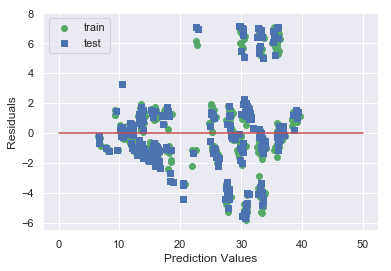

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_train_pred, y_train - y_train_pred, c='g', marker='o', s=35,label='train')
ax.scatter(pred, y_test - pred, c='b', marker='s', s=35,label='test')
ax.plot([0,50], [0,0], c='r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Prediction Values')
plt.legend(loc='upper left')